In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

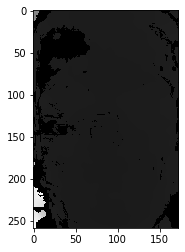

In [2]:
data = 'depth_roi_data/depth_roi.png'
depth_roi = cv2.imread(data, cv2.IMREAD_ANYDEPTH)

plt.imshow(depth_roi, cmap='gray')

In [3]:
def compute_histogram(img, nbins):
    hist = np.zeros(shape=(nbins))
    flat_img = img.ravel()
    
    for idx in range(0, flat_img.shape[0]):
        if flat_img[idx] < nbins:
            hist[flat_img[idx]] += 1
        
    return hist

def smooth_out(hist, window_size=10):
    kernel = np.ones(shape=(2 * window_size))
    for i in range(0, hist.shape[0]):
        summation = 0.0
        count = 0
        for j in range(-window_size, window_size):
            idx = i + j
            if idx < 0 or idx > hist.shape[0] - window_size:
                continue
            summation += kernel[j] * hist[i + j]
            count += 1
        hist[i] = summation // count
        
    return hist

def find_separate_distributions(hist):
    blobs = []
    is_interrupted = False
    start_idx = -1
    for idx in range(0, hist.shape[0]):
        curr_f = hist[idx]
        if not is_interrupted and curr_f > 0:
            print('Start of distribution')
            is_interrupted = True
            start_idx = idx
            continue
        if is_interrupted and curr_f == 0:
            is_interrupted = False
            if start_idx >= 0 and (idx - 1) > start_idx:
                print('Identified a blob distribution')
                blobs.append(hist[start_idx : idx - 1])
    return blobs
                
def find_local_maxima(hist):
    peaks = []
    for idx in range(2, hist.shape[0] - 2):
        curr_f = hist[idx]
        prev_idx = idx - 1
        next_idx  = idx + 1
        prev_slope = (hist[idx] - hist[prev_idx]) / (idx - prev_idx)
        next_slope = (hist[next_idx] - hist[idx]) / (next_idx - idx)
        is_same_sign = (prev_slope > 0) == (next_slope > 0)
        if not is_same_sign and curr_f > 0:
            print('Found a local maximum')
            peaks.append((curr_f, idx))
    return peaks
                
#HWC
def find_dominant_pxl_value(img):
    rows = img.shape[0]
    cols = img.shape[1]
    print('Rows: ', rows)
    print('Cols: ', cols)
    c_x = img.shape[0] // 2
    c_y = img.shape[1] // 2
    print('({}, {})'.format(c_x, c_y))
    pxl = img[c_y, c_x]
    print('Center of image: ', pxl)
    r = 1
    while pxl == 0:
        theta_degrees = np.random.uniform(low=0, high=360)
        theta_rad = (np.pi * theta_degrees) / 180.0
        x = np.cos(theta_rad) * r
        y = np.sin(theta_rad) * r
        
        pxl = img[y, x]
        
    print('Random pixel chosen: ', pxl)
    
    diff_thresh = 100 #mm
    mask = np.zeros_like(img)
    for row in range(0, rows):
        for col in range(0, cols):
            if np.abs(img[row][col] - pxl) <= diff_thresh:
                mask[row][col] = 1
    non_zero = cv2.countNonZero(mask)
    return mask, non_zero

Start of distribution
Identified a blob distribution
Start of distribution
Identified a blob distribution
Start of distribution
Identified a blob distribution
Start of distribution
Identified a blob distribution
Start of distribution
Identified a blob distribution
Start of distribution
Identified a blob distribution
Start of distribution
Identified a blob distribution
7


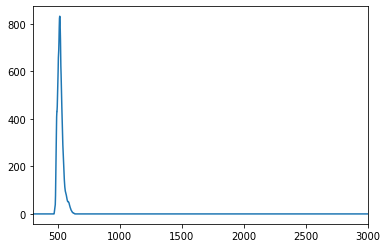

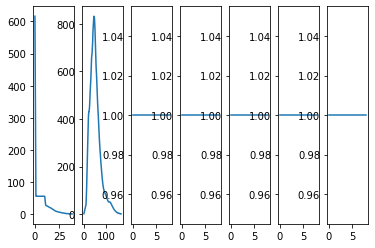

In [4]:
depth_hist = compute_histogram(depth_roi, nbins=65535)
depth_hist = smooth_out(depth_hist)

plt.xlim(300, 3000)
plt.plot(depth_hist)

blobs = find_separate_distributions(depth_hist)
print(len(blobs))

fig, axes = plt.subplots(1, len(blobs))
for idx in range(0, len(blobs)):
    axes[idx].plot(blobs[idx])

In [5]:
peaks = find_local_maxima(depth_hist)
peaks = sorted(peaks, key=lambda pair: pair[0], reverse=True)
print(peaks)
win = 30 # mm
min_acceptable_freq = 30
filtered_peaks = [peaks[0][1]]
max_f = peaks[0][0]
for idx in range(1, len(peaks)):
    if np.abs(filtered_peaks[-1] - peaks[idx][1]) > win:
        if peaks[idx][0] > min_acceptable_freq:
            filtered_peaks.append(peaks[idx])
    else:
        if np.abs(max_f - peaks[idx][0]) <= min_acceptable_freq:
            filtered_peaks[-1] = (filtered_peaks[-1] + peaks[idx][1]) / 2.0
print(filtered_peaks)

Found a local maximum
Found a local maximum
Found a local maximum
Found a local maximum
Found a local maximum
Found a local maximum
Found a local maximum
Found a local maximum
[(832.0, 515), (431.0, 492), (431.0, 493), (1.0, 4261), (1.0, 4279), (1.0, 4315), (1.0, 4352), (1.0, 4371)]
[515]


Rows:  259
Cols:  173
(129, 86)
Center of image:  509
Random pixel chosen:  509


/home/filipgrigorov/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in ushort_scalars


Non zero:  25211
Zero:  19596
Dominant pixel value: 529.5 mm
14.457062393399724
37.457062393399724
36.457062393399724
3731.5429376066004
3749.5429376066004
3785.5429376066004
3822.5429376066004
3841.5429376066004
[(515, 14.457062393399724), (492, 37.457062393399724), (493, 36.457062393399724)]


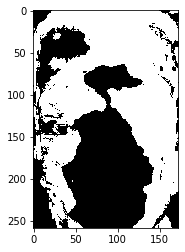

In [6]:
mask, non_zero_pxls = find_dominant_pxl_value(depth_roi)
dom_d = np.mean(depth_roi[mask == 1])

plt.imshow(mask, cmap='gray')
print('Non zero: ', non_zero_pxls)
print('Zero: ', depth_roi.shape[0] * depth_roi.shape[1] - non_zero_pxls)
print('Dominant pixel value: {:.4} mm'.format(dom_d))

thresh = 50 # mm

dom_peaks = []
for idx in range(0, len(peaks)):
    rmse = np.sqrt((peaks[idx][1] - dom_d)**2)
    print(rmse)
    if rmse < thresh:
        dom_peaks.append((peaks[idx][1], rmse))
sorted(dom_peaks, key=lambda p: p[1])

print(dom_peaks)

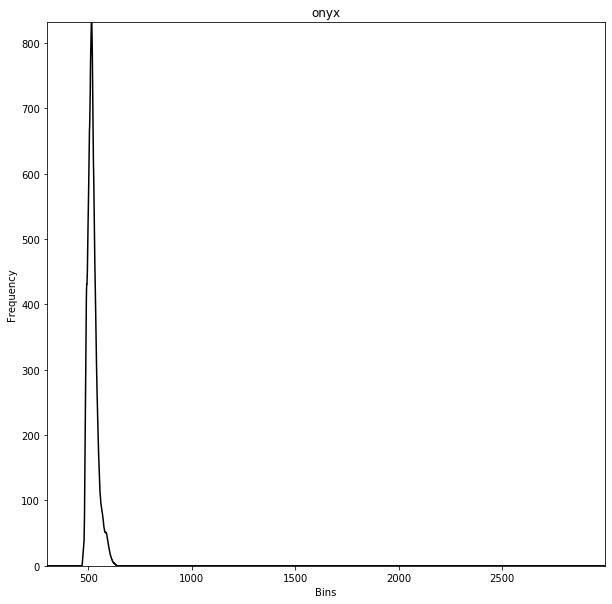

In [7]:
fig = plt.figure(figsize=(10, 10))

range_vals = list(range(300, 3000))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title('onyx')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Bins')
ax1.set_xlim([range_vals[0], range_vals[-1]])
ax1.set_ylim([0, np.max(depth_hist[range_vals])])
ax1.plot(depth_hist, color='black')